# Causal Inference Modeling of COMPAS data

### Criterion for Bias
- 1) TP and TN Rate by Race
- 2) Intervention by Race
- 3) Counterfactual Fairness by Race
- 4) Natural Direct Effects Identification of Race to Recitivism
- 5) Natural Indirect Effects Identification of Race to Recitivism

### 3 SCMs of Race towards Recitivism Predictions
- 1) Indirect (Almost all expected, with some understandable results)
    - 1) TP and TN Rate by Race (Expected: 1 - 3% difference between race is understndable, but non zero value is expected)
    - 2) Intervention by Race (Expected: Small effect of around 5% is understandable, but not zero is expected)
    - 3) Counterfactual Fairness by Race (Expected: Large of 43%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: No effect detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: -24% of White -> Will not Recommit)
- 2) Direct (Expected)
    - 1) TP and TN Rate by Race (Expected: Large bias)
    - 2) Intervention by Race (Expected: Large around 10-15%)
    - 3) Counterfactual Fairness by Race (Expected: Large around 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: Large value of -23%)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: Large value of -24%)
- 3) Unaware (Expected, when natural indirect effect identification can likely be attributed to unobserved confoudner)
    - 1) TP and TN Rate by Race (Expected: Low gap of 4-5% is expected due to in line with indirect, and expected from being non-zero)
    - 2) Intervention by Race (Expected: No impact)
    - 3) Counterfactual Fairness by Race (Expected, large impact of 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected, no impact detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Largely Expected: Large impact of -24% was detected. Likely due to unobserved confounder of race.)

In [153]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from statistics import mean

%matplotlib inline

pyro.set_rng_seed(42)

# Data Import

In [140]:
data_file_path = 'data/compas-scores-two-years_short-priors_count.csv'

# Model 1 - Indirect Race Path

### Read Model Parameters

In [141]:
# race
df = pd.read_csv('data/model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )



# c_charge_degree
df = pd.read_csv('data/model1_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define Model

In [145]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[c_charge_degree])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid

### TP vs FN Rate

In [143]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = c_charge_degree_alias.index( row['c_charge_degree'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "c_charge_degree": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0


KeyboardInterrupt: 

### Intervention
P(two_year_recid=1 | do(race=1)) - P(two_year_recid=1 | do(race=0))

In [6]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


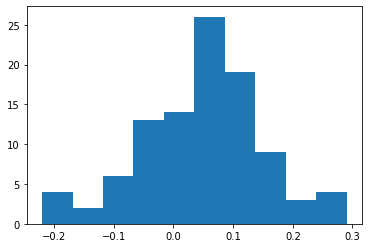

In [7]:
plt.hist(ls)
plt.show()

In [8]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.0473


### Counterfactual fairness

P(two_year_recid race=0 = 1 | race = 1, two_year_recid = 0)

In [9]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


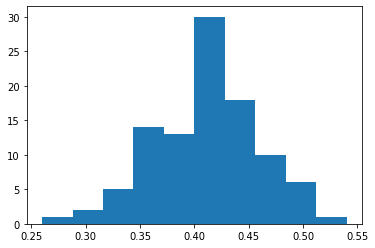

In [10]:
plt.hist(ls) 
plt.show()

In [11]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.40950000000000025


### Natural Effects

#### Natural Direct Effects

In [12]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [13]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [14]:
e1_avg

0.606

In [15]:
e2_avg

0.573

In [16]:
e1_avg - e2_avg

0.03300000000000003

#### Natural Indirect Effect

In [17]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(0)})() for _ in range(1000)]

In [18]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [19]:
e1_avg - e2_avg

-0.25099999999999995

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [158]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [160]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.473


#### Sufficiency

In [161]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [163]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.488


## Model 2 - Direct Race Path

### Read Model Parameters

In [164]:
# race
df = pd.read_csv('data/model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# c_charge_degree
df = pd.read_csv('data/model2_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['c_charge_degree'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in c_charge_degree_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

### Define model

In [165]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][c_charge_degree]))
    return two_year_recid

In [22]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = c_charge_degree_alias.index( row['c_charge_degree'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "c_charge_degree": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.4897733554449972
False negative rate (Black)      :  0.43932167461579225
Accuracy (Black)      :   0.5359848484848485
AUC (Black)      :   0.5354524849696053

False positive rate (White)      :  0.36845683208701563
False negative rate (White)      :  0.5798575788402849
Accuracy (White)      :   0.5468622656886716
AUC (White)      :   0.5258427945363497

False positive rate Gap: 0.1213165233579816
False negative rate Gap: 0.14053590422449264


### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [23]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


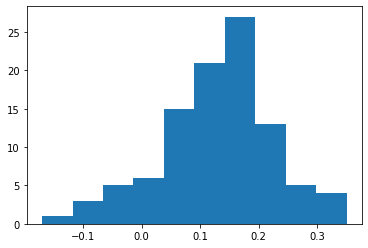

In [24]:
plt.hist(ls) 
plt.show()

In [25]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.12870000000000004


### Counterfactual fairness

In [26]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:03<00:00, 26.14it/s]


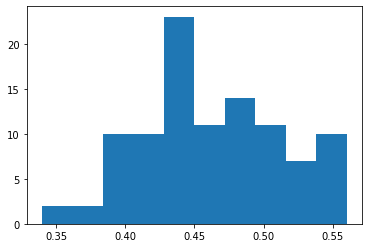

In [27]:
plt.hist(ls)
plt.show()

In [28]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4633000000000001


### Natural effects

#### Natural Direct Effects

In [29]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [30]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [31]:
e1_avg

0.506

In [32]:
e2_avg

0.597

In [33]:
e1_avg - e2_avg

-0.09099999999999997

#### Natural Indirect Effects

In [34]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'c_charge_degree': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [35]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [36]:
e1_avg - e2_avg

-0.239

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [166]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [167]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.503


#### Sufficiency

In [168]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [169]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.414


## Model 3

### Read data

In [170]:
# race
df = pd.read_csv('data/model3_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model3_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model3_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# c_charge_degree
df = pd.read_csv('data/model3_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in c_charge_degree_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

c_charge_degree_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model3_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [171]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[c_charge_degree]))
    return two_year_recid


### Association

In [39]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = c_charge_degree_alias.index( row['c_charge_degree'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "c_charge_degree": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.4540682414698163
False negative rate (Black)      :  0.4835287548855388
Accuracy (Black)      :   0.5316558441558441
AUC (Black)      :   0.5312015018223225

False positive rate (White)      :  0.4151084517576664
False negative rate (White)      :  0.5147717099373321
Accuracy (White)      :   0.5395273023634882
AUC (White)      :   0.5350599191525007

False positive rate Gap: 0.03895978971214986
False negative rate Gap: 0.03124295505179331


### Intervention

In [40]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [41]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


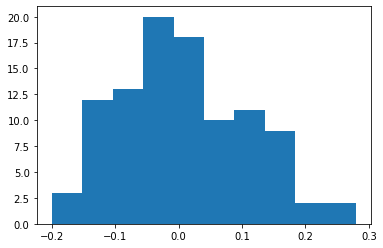

In [42]:
plt.hist(ls)
plt.show()

In [43]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.007999999999999998


### Counterfactual fairness

In [44]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [45]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


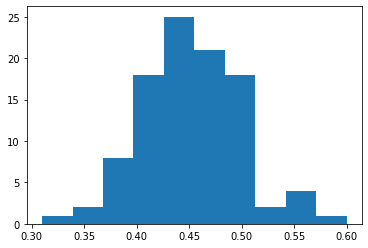

In [46]:
plt.hist(ls)
plt.show()

In [47]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.45159999999999995


In [48]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 1)

In [61]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


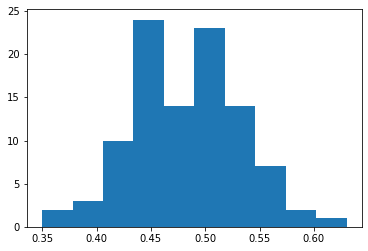

In [62]:
plt.hist(ls)
plt.show()

In [63]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4834000000000001


### Natural effects

#### Natural Direct Effects

In [51]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [52]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [53]:
e1_avg

0.583

In [54]:
e2_avg

0.598

In [55]:
e1_avg - e2_avg

-0.015000000000000013

#### Natural Indirect Effects

In [56]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'c_charge_degree': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [57]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [58]:
e1_avg - e2_avg

-0.26399999999999996

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [172]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [173]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.47


#### Sufficiency

In [174]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['c_charge_degree']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [175]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.371
